## 1. Model Training
We train a data prediction model using darts framework and NBEATS Deep Learning model.

In [1]:
%pip install darts==0.25.0 pandas==1.4.4 numpy==1.22.4 patsy==0.5.2 scikit-learn==1.1.2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import digitalhub as dh

proj = dh.get_or_create_project('parcheggi-demo')
di = proj.get_dataitem('dataset')
df = di.as_df()
df.head()

,parcheggio,data,posti_liberi,posti_occupati,posti_totali,lat,lon
0,Riva Reno,2024-06-07T01:59:00+00:00,369.0,101.0,470,44.501153,11.336062
1,VIII Agosto,2024-06-07T02:09:00+00:00,485.0,140.0,625,44.500297,11.345368
2,Autostazione,2024-06-07T02:09:00+00:00,244.0,21.0,265,44.504422,11.346514
3,VIII Agosto,2024-06-07T02:34:00+00:00,487.0,138.0,625,44.500297,11.345368
4,Riva Reno,2024-06-07T02:49:00+00:00,369.0,101.0,470,44.501153,11.336062


### 1.1. Prepare data

Clean data: convert date to datetime and calculate occupied ratio, remove redundant columns.

In [3]:
import datetime
import pandas as pd

window = 60

df_clean = df.copy()
df_clean.data = pd.to_datetime(df_clean.data, utc=True)
df_clean['occupied'] = df_clean.posti_occupati / df_clean.posti_totali
df_clean['date_time_slice'] = df_clean.data.dt.round('30min').dt.tz_convert(None)
df_clean = df_clean[df_clean.date_time_slice >= (datetime.datetime.today() - pd.DateOffset(window))]
df_clean = df_clean[df_clean.date_time_slice <= (datetime.datetime.today() - pd.DateOffset(1))]
df_clean.posti_occupati = df_clean.apply(lambda x: max(0, min(x['posti_totali'], x['posti_occupati'])), axis=1)
df_clean['occupied'] = df_clean.posti_occupati / df_clean.posti_totali
df_clean = df_clean.drop(columns=['lat', 'lon', 'data', 'posti_totali', 'posti_liberi', 'posti_occupati'])
df_clean.head()

,parcheggio,occupied,date_time_slice
54,VIII Agosto,0.844800,2024-06-07 12:00:00
55,Autostazione,0.313208,2024-06-07 12:00:00
56,VIII Agosto,0.804800,2024-06-07 12:30:00
57,VIII Agosto,0.812800,2024-06-07 12:30:00
58,VIII Agosto,0.788800,2024-06-07 12:30:00


### 1.2. Create multiple time series

/tmp/ipykernel_6608/2711141629.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parc_df['hour'] = parc_df.date_time_slice.dt.hour
/tmp/ipykernel_6608/2711141629.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parc_df['dow'] = parc_df.date_time_slice.dt.dayofweek
/tmp/ipykernel_6608/2711141629.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Axes: xlabel='date_time_slice'>

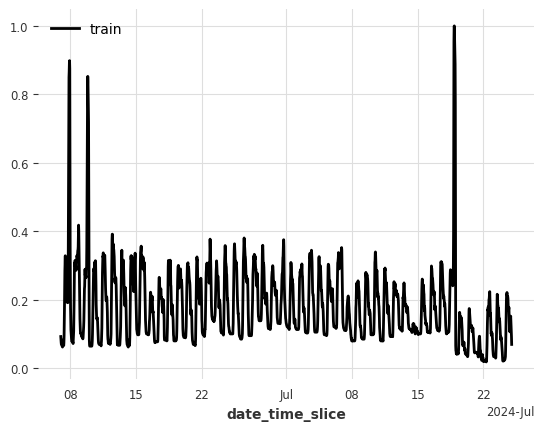

In [4]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

split_ratio = 0.8

def fill_missing(parc_df):
    missing = []  # List to store timestamps for which values could not be filled
    temp = pd.Series(parc_df.index.date).value_counts()  # Count the occurrences of each date
    temp = temp[temp < 48]  # Filter dates with less than 48 occurrences
    temp.sort_index(inplace=True)  # Sort the dates in ascending order
    for t in temp.index:  # Iterate through the filtered dates
        for h in range(24):  # Iterate through 24 hours
            for half_hour in [0, 30]:  # Iterate through 0 and 30 minutes
                ts = datetime.datetime(t.year, t.month, t.day, h, half_hour)  # Create a timestamp
                if ts not in parc_df.index:  # If the timestamp is missing in the DataFrame
                    if ts - datetime.timedelta(days=7) in parc_df.index:  # Check if the previous week's timestamp is available
                        parc_df.loc[ts] = parc_df.loc[ts - datetime.timedelta(days=7)].copy()  # Copy values from the previous week
                    elif ts + datetime.timedelta(days=7) in parc_df.index:  # Check if the next week's timestamp is available
                        parc_df.loc[ts] = parc_df.loc[ts + datetime.timedelta(days=7)].copy()  # Copy values from the next week
                    else:
                        missing.append(ts)  # If values cannot be filled, add the timestamp to the missing list
    return missing 
parcheggi = ['Riva Reno' ,'VIII Agosto']# df_clean['parcheggio'].unique()

train_sets, val_sets = [], []

for parcheggio in parcheggi:
    parc_df = df_clean[df_clean['parcheggio'] == parcheggio]
    parc_df['hour'] = parc_df.date_time_slice.dt.hour
    parc_df['dow'] = parc_df.date_time_slice.dt.dayofweek
    parc_df = parc_df.drop(columns=['parcheggio'])
    parc_df = parc_df.groupby('date_time_slice').agg({'occupied': 'mean', 'hour': 'first', 'dow': 'first'})
    fill_missing(parc_df)
    ts = TimeSeries.from_dataframe(parc_df,  value_cols='occupied', freq='30min')
    ts_scaled = Scaler().fit_transform(ts)

    split = int(len(ts_scaled) * (1 - split_ratio))

    train, val = ts_scaled[:-split], ts_scaled[-split:]
    train_sets.append(train)
    val_sets.append(val)
    
train_sets[0].plot(label='train')

In [5]:
from darts.models import NBEATSModel

multimodel =  NBEATSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=1,
        random_state=0
    )

multimodel.fit(train_sets)

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | stacks        | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=1, random_state=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date_time_slice'>

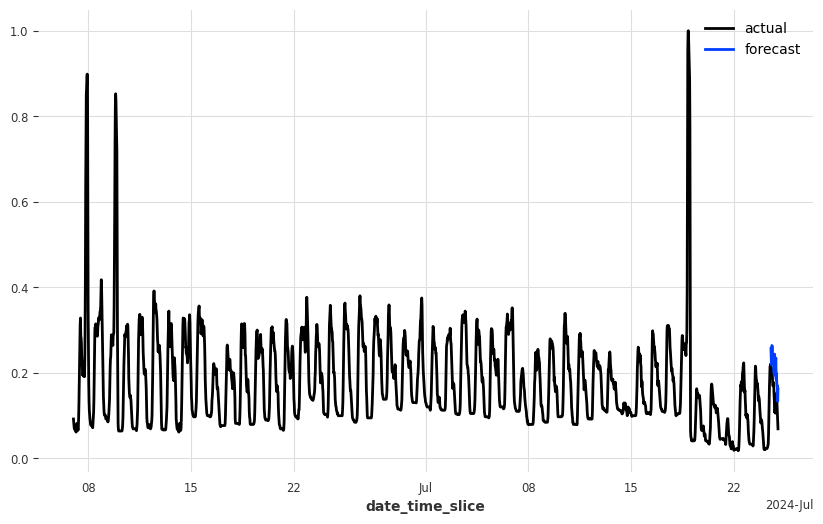

In [6]:
import matplotlib.pyplot as plt

pred = multimodel.predict(n=24, series=train_sets[0][:-24])

plt.figure(figsize=(10, 6))
train_sets[0].plot(label="actual")
pred.plot(label="forecast")

In [7]:
from darts.metrics import mape, smape, mae

metrics = {
    "mape": mape(train_sets[0], pred),
    "smape": smape(train_sets[0], pred),
    "mae": mae(train_sets[0], pred)
}
metrics

{'mape': 49.32425052357362,
 'smape': 36.85724142338202,
 'mae': 0.06279265622065518}

## 2. ML Ops
With the help of the platform, we will create the training function, train a parking occupation prediction model, and deploy it to the cluster as an inference API.

### 2.1. Initalization
Create the working context: data management project for the parking data processing. Project is a placeholder for the code, data, and management of the parking data operations. 

In [8]:
import digitalhub as dh

ml_proj = dh.get_or_create_project("parcheggi-demo")

### 2.2. ML training function
We convert the ML operations into a function - single executable operation that can be executed in the platform.

In [9]:
%%writefile "train_multimodel.py"

import pandas as pd
from digitalhub_runtime_python import handler
from darts import TimeSeries

from darts.models import NBEATSModel
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from zipfile import ZipFile

import logging
logging.disable(logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore")

import datetime

import pandas as pd
import datetime

from pickle import dumps

def fill_missing(parc_df):
    missing = []  # List to store timestamps for which values could not be filled
    temp = pd.Series(parc_df.index.date).value_counts()  # Count the occurrences of each date
    temp = temp[temp < 48]  # Filter dates with less than 48 occurrences
    temp.sort_index(inplace=True)  # Sort the dates in ascending order
    for t in temp.index:  # Iterate through the filtered dates
        for h in range(24):  # Iterate through 24 hours
            for half_hour in [0, 30]:  # Iterate through 0 and 30 minutes
                ts = datetime.datetime(t.year, t.month, t.day, h, half_hour)  # Create a timestamp
                if ts not in parc_df.index:  # If the timestamp is missing in the DataFrame
                    if ts - datetime.timedelta(days=7) in parc_df.index:  # Check if the previous week's timestamp is available
                        parc_df.loc[ts] = parc_df.loc[ts - datetime.timedelta(days=7)].copy()  # Copy values from the previous week
                    elif ts + datetime.timedelta(days=7) in parc_df.index:  # Check if the next week's timestamp is available
                        parc_df.loc[ts] = parc_df.loc[ts + datetime.timedelta(days=7)].copy()  # Copy values from the next week
                    else:
                        missing.append(ts)  # If values cannot be filled, add the timestamp to the missing list
    return missing  # Return the list of timestamps for which values could not be filled


@handler()
def train_model(project, parkings_di,n_epochs: int = 1, window: int = 60, 
                input_chunk_length: int = 24, output_chunk_length: int = 12, 
                split_ratio: float = 0.8):

    # Load the input data
    df_source = parkings_di.as_df()
    # Clean the data
    df_clean = df_source.copy()
    df_clean.data = pd.to_datetime(df_clean.data, utc=True)
    df_clean['occupied'] = df_clean.posti_occupati / df_clean.posti_totali
    df_clean['date_time_slice'] = df_clean.data.dt.round('30min').dt.tz_convert(None)
    df_clean = df_clean[df_clean.date_time_slice >= (datetime.datetime.today() - pd.DateOffset(window))]
    df_clean = df_clean[df_clean.date_time_slice <= (datetime.datetime.today() - pd.DateOffset(1))]
    df_clean.posti_occupati = df_clean.apply(lambda x: max(0, min(x['posti_totali'], x['posti_occupati'])), axis=1)
    df_clean['occupied'] = df_clean.posti_occupati / df_clean.posti_totali
    df_clean = df_clean.drop(columns=['lat', 'lon', 'data', 'posti_totali', 'posti_liberi', 'posti_occupati'])
    #parcheggi = df_clean['parcheggio'].unique()
    parcheggi = ['Riva Reno' ,'VIII Agosto']
    
    train_sets, val_sets = [], []

    # Process data for each parking lot
    for parcheggio in parcheggi:
        parc_df = df_clean[df_clean['parcheggio'] == parcheggio]
        parc_df['hour'] = parc_df.date_time_slice.dt.hour
        parc_df['dow'] = parc_df.date_time_slice.dt.dayofweek
        parc_df = parc_df.drop(columns=['parcheggio'])
        parc_df = parc_df.groupby('date_time_slice').agg({'occupied': 'mean', 'hour': 'first', 'dow': 'first'})
        fill_missing(parc_df)
        ts = TimeSeries.from_dataframe(parc_df,  value_cols='occupied', freq='30min')
        ts_scaled = Scaler().fit_transform(ts)
        
        split = int(len(ts_scaled) * (1 - split_ratio))

        # Split data into training and validation sets
        train, val = ts_scaled[:-split], ts_scaled[-split:]
        train_sets.append(train)
        val_sets.append(val)

    # Train a multi-model using the NBEATS algorithm
    multimodel =  NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        n_epochs=n_epochs,
        random_state=0
    )

    # Fit the model to the training sets
    multimodel.fit(train_sets)
    pred = multimodel.predict(n=output_chunk_length*2, series=train_sets[0][:-output_chunk_length*2])

    multimodel.save("parcheggi_predictor_model.pt")
    with ZipFile("parcheggi_predictor_model.pt.zip", "w") as z:
        z.write("parcheggi_predictor_model.pt")
        z.write("parcheggi_predictor_model.pt.ckpt")
    metrics = {
        "mape": mape(train_sets[0], pred),
        "smape": smape(train_sets[0], pred),
        "mae": mae(train_sets[0], pred)
    }

    project.log_model(
        name="modello_parcheggi", 
        kind="model", 
        source_path="parcheggi_predictor_model.pt.zip", 
        algorithm="darts.models.NBEATSModel",
        framework="darts",
        metrics=metrics
    )


Writing train_multimodel.py


In [10]:
func = ml_proj.new_function(name="training_model",
                         kind="python",
                         python_version="PYTHON3_9",
                         source={"source": "train_multimodel.py", "handler": "train_model"})

In [11]:
func.run(action="build", instructions=["pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu","pip3 install darts==0.25.0 pandas==1.4.4 numpy==1.22.4 patsy==0.5.2 scikit-learn==1.1.2"])

{'project': 'parcheggi-demo', 'id': '15eedf8a-b0fe-4268-bec8-5fef2d7f4bff', 'kind': 'python+run', 'key': 'store://parcheggi-demo/runs/python+run/15eedf8a-b0fe-4268-bec8-5fef2d7f4bff', 'metadata': {'project': 'parcheggi-demo', 'name': '15eedf8a-b0fe-4268-bec8-5fef2d7f4bff', 'created': '2024-08-06T11:38:42.48Z', 'updated': '2024-08-06T11:38:42.494Z', 'created_by': 'tenant1userid', 'updated_by': 'tenant1userid'}, 'spec': {'task': 'python+build://parcheggi-demo/training_model:5b7f80fe-7b12-419d-b056-034c90d91fdb', 'local_execution': False, 'source': {'source': 'train_multimodel.py', 'handler': 'train_model', 'base64': 'CmltcG9ydCBwYW5kYXMgYXMgcGQKZnJvbSBkaWdpdGFsaHViX3J1bnRpbWVfcHl0aG9uIGltcG9ydCBoYW5kbGVyCmZyb20gZGFydHMgaW1wb3J0IFRpbWVTZXJpZXMKCmZyb20gZGFydHMubW9kZWxzIGltcG9ydCBOQkVBVFNNb2RlbApmcm9tIGRhcnRzLm1ldHJpY3MgaW1wb3J0IG1hcGUsIHNtYXBlLCBtYWUKZnJvbSBkYXJ0cy5kYXRhcHJvY2Vzc2luZy50cmFuc2Zvcm1lcnMgaW1wb3J0IFNjYWxlcgpmcm9tIHppcGZpbGUgaW1wb3J0IFppcEZpbGUKCmltcG9ydCBsb2dnaW5nCmxvZ2dpbmcuZ

### 2.3. Train model
Execute train model function. As a result, the function produces a ML model that is uploaded to the platform storage, versioned, and enriched with metadata (e.g., metrics).

In [12]:
data_item_download = di.key
train_run = func.run(action="job", inputs={"parkings_di":data_item_download}, parameters={"n_epochs": 50})

### 2.4. Deploy Model
Next, we deploy the model in the serving function. Given that the interaction does not correspond to a standard MLRun model server, we will deploy the function as a custom server. See the implementation of ``serve_multimodel.py`` for more details. 

For this, we add the model to the serving function in the initialization method.

In [13]:
%%writefile "serve_multimodel.py"

from darts.models import NBEATSModel
from zipfile import ZipFile
from darts import TimeSeries
import json
import pandas as pd

def init(context):
    # Qua ti setti il nome del modello che vuoi caricare
    model_name = "modello_parcheggi"

    # prendi l'entity model sulla base del nome
    model = context.project.get_model(model_name)
    path = model.download()
    local_path_model = "extracted_model/"
    # Qua fai unzip immagino
    with ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(local_path_model)
    
    # codice che carica il modello
    input_chunk_length = 24
    output_chunk_length = 12
    name_model_local = local_path_model +"parcheggi_predictor_model.pt"
    mm = NBEATSModel(
            input_chunk_length,
            output_chunk_length
    ).load(name_model_local)

    # settare model nel context di nuclio (non su project che è il context nostro)
    # context.setattr("model", mm)
    setattr(context, "model", mm)

def serve(context, event):

    # Sostanzialmente invochiamo la funzione con una chiamata REST
    # Nel body della richiesta mandi l'inference input
    
    if isinstance(event.body, bytes):
        body = json.loads(event.body)
    else:
        body = event.body
    context.logger.info(f"Received event: {body}")
    inference_input = body["inference_input"]
    
    pdf = pd.DataFrame(inference_input)
    pdf['date'] = pd.to_datetime(pdf['date'], unit='ms')

    ts = TimeSeries.from_dataframe(
        pdf,
        time_col="date",
        value_cols="value",
        freq="30min"
    )
    
    output_chunk_length = 12
    result = context.model.predict(n=output_chunk_length*2, series=ts)
    # Convert the result to a pandas DataFrame, reset the index, and convert to a list
    jsonstr = result.pd_dataframe().reset_index().to_json(orient='records')
    return json.loads(jsonstr)

Overwriting serve_multimodel.py


In [14]:
func = ml_proj.new_function(name="serve_model",
                            kind="python",
                            python_version="PYTHON3_9",
                            base_image = "python:3.9",
                            source={
                                 "source": "serve_multimodel.py",
                                 "handler": "serve",
                                 "init_function": "init"})

In [15]:
run_build_model_serve = func.run(action="build",instructions=["pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu","pip3 install darts==0.25.0 pandas==1.4.4 numpy==1.22.4 patsy==0.5.2 scikit-learn==1.1.2"])

Let us wait till the build is finished and then expose the function as a service. For this, we need to run the ``serve`` action on the function.

In [16]:
run_serve_model = func.run(action="serve")

### Test the API

Once deployed, we can test the API. Let us test the latest data taken from the OpenData API. We take the latest data regarding the Riva Reno parking and convert it into the format expected by the API: list of dates and values representing the occupation of the parking (percentage).


In [17]:
import datetime 
import requests
import json

date_str = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
parking_str='Riva Reno'
API_URL = f'https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/disponibilita-parcheggi-storico/records?where=data%3C%3D%27{date_str}%27%20and%20parcheggio%3D%27{parking_str}%27&order_by=data%20DESC&limit=100'

latest_data_file = 'last_records.json'

with requests.get(API_URL) as r:
    with open(latest_data_file, "wb") as f:
        f.write(r.content)

with open(latest_data_file) as f:
    json_data = json.load(f)
    df_latest = pd.json_normalize(json_data['results']).drop(columns=['guid', 'occupazione']).rename(columns={"coordinate.lon": "lon", "coordinate.lat": "lat"})
    df_latest.data = df_latest.data.astype('datetime64')
    df_latest['value'] = df_latest.posti_occupati / df_latest.posti_totali
    df_latest['date'] = df_latest.data.dt.round('30min')
    df_latest = df_latest.drop(columns=['parcheggio'])
    df_latest = df_latest.groupby('date').agg({'value': 'mean'})


jsonstr = df_latest.reset_index().to_json(orient='records')
arr = json.loads(jsonstr)
arr

[{'date': 1722884400000, 'value': 0.2212765957},
 {'date': 1722886200000, 'value': 0.2156028369},
 {'date': 1722888000000, 'value': 0.2141843972},
 {'date': 1722889800000, 'value': 0.2113475177},
 {'date': 1722891600000, 'value': 0.204964539},
 {'date': 1722893400000, 'value': 0.204964539},
 {'date': 1722895200000, 'value': 0.204964539},
 {'date': 1722897000000, 'value': 0.2028368794},
 {'date': 1722898800000, 'value': 0.2},
 {'date': 1722900600000, 'value': 0.1971631206},
 {'date': 1722902400000, 'value': 0.1936170213},
 {'date': 1722904200000, 'value': 0.1921985816},
 {'date': 1722906000000, 'value': 0.1921985816},
 {'date': 1722907800000, 'value': 0.190070922},
 {'date': 1722909600000, 'value': 0.1893617021},
 {'date': 1722911400000, 'value': 0.1893617021},
 {'date': 1722913200000, 'value': 0.1893617021},
 {'date': 1722915000000, 'value': 0.1893617021},
 {'date': 1722916800000, 'value': 0.1893617021},
 {'date': 1722918600000, 'value': 0.1893617021},
 {'date': 1722920400000, 'value':

In [18]:
run_serve_model.refresh()
SERVICE_URL = run_serve_model.status.to_dict()["service"]["url"]

with requests.post(f'http://{SERVICE_URL}', json={"inference_input":arr}) as r:
    res = r.content
print(res)

b'[{"date": 1722947400000, "value": 0.2569619106}, {"date": 1722949200000, "value": 0.2690154861}, {"date": 1722951000000, "value": 0.2429872122}, {"date": 1722952800000, "value": 0.2170893603}, {"date": 1722954600000, "value": 0.2014962612}, {"date": 1722956400000, "value": 0.2108028826}, {"date": 1722958200000, "value": 0.1898471038}, {"date": 1722960000000, "value": 0.1600334968}, {"date": 1722961800000, "value": 0.2070903138}, {"date": 1722963600000, "value": 0.1602838456}, {"date": 1722965400000, "value": 0.1795623165}, {"date": 1722967200000, "value": 0.1552370516}, {"date": 1722969000000, "value": 0.1820815608}, {"date": 1722970800000, "value": 0.1856707805}, {"date": 1722972600000, "value": 0.1644394259}, {"date": 1722974400000, "value": 0.1519836381}, {"date": 1722976200000, "value": 0.1326024841}, {"date": 1722978000000, "value": 0.1395891558}, {"date": 1722979800000, "value": 0.1263856761}, {"date": 1722981600000, "value": 0.1186660597}, {"date": 1722983400000, "value": 0.14